# Final EDA for Bill Classification and NLP:

In [624]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


import config_final as config
from schema import DbSchema

import pickle


**Connect to Database**

In [625]:
bills_db = DbSchema(config)


In [626]:
#Query all titles and Passing

df = bills_db.query("""
    SELECT
        *
    FROM con_bills.current_bills as cb
    JOIN con_bills.topics as tp
    ON cb.BillID = tp.BillID
    WHERE cb.Cong >=110
    """)
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,PLawNum,ImpBill,Majority,Major,Minor,URL,Summary,Index,BillID,dominant_topic
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,Became Public Law No: 110-53.,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,1,110-HR-1,5
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,0,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,2,110-HR-10,10
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,0,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,3,110-HR-100,4
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,4,110-HR-1000,10
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,0,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,5,110-HR-1001,5


In [627]:
# Drop the third party from 
indexNames = df[ df['Party'] == 328.0 ].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

df.Party.value_counts()

100.0    30400
200.0    20660
Name: Party, dtype: int64

In [628]:
topic_dict = {0: 'border_enforcement', 1: 'taxes', 2: 'grants_higher_ed', 3: 'healthcare', 4: 'budget_appropriations', 
              5: 'us_interior', 6: 'military', 7: 'designations', 8: 'energy_fuel', 9: 'entitlements_ss', 10: 'tariffs', 
              11: 'education', 12: 'veterans_affairs'}



In [703]:
topic_list = ['border_enforcement', 'taxes', 'grants_higher_ed', 'healthcare', 'budget_appropriations',
             'us_interior', 'military', 'designations', 'energy_fuel', 'entitlements_ss', 'tariffs', 'education', 'veterans_affairs']

In [629]:
df['dominant_topic_named'] = df['dominant_topic'].map(topic_dict)

In [630]:
df.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,ImpBill,Majority,Major,Minor,URL,Summary,Index,BillID,dominant_topic,dominant_topic_named
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,1,110-HR-1,5,us_interior
1,110-HR-10,hr,0,110,0.0,2007-01-04 00:00:00,0,0,Reserved for Speaker.,0,...,1,1,20.0,2002.0,https://www.congress.gov/bill/110th-congress/h...,,2,110-HR-10,10,tariffs
2,110-HR-100,hr,0,110,10.0,2007-01-04 00:00:00,0,0,To amend the Higher Education Act of 1965 to p...,0,...,1,1,6.0,601.0,https://www.congress.gov/bill/110th-congress/h...,Veterans' Equity in Education Act of 2007 - Am...,3,110-HR-100,4,budget_appropriations
3,110-HR-1000,hr,0,110,286.0,2007-02-12 00:00:00,0,0,To award a congressional gold medal to Edward ...,0,...,0,1,20.0,2006.0,https://www.congress.gov/bill/110th-congress/h...,Edward William Brooke III Congressional Gold M...,4,110-HR-1000,10,tariffs
4,110-HR-1001,hr,0,110,0.0,2007-02-12 00:00:00,0,0,To amend the Haitian Hemispheric Opportunity t...,0,...,1,1,19.0,1921.0,https://www.congress.gov/bill/110th-congress/h...,Amends the Caribbean Basin Economic Recovery A...,5,110-HR-1001,5,us_interior


In [631]:
# df.loc[:,['dominant_topics']].transform(lambda x: x.map(lambda x: topic_dict.get(x,x)))

# Sorted Dataframes for Passed Bills and Not Passed Bills

In [680]:
#PASSED BILL ONLY
passed_bills = df[df['PassH'] == 1]
len(passed_bills)

4025

In [685]:
passed_bills.head()

,BillID,BillType,Chamber,Cong,Cosponsr,IntrDate,Mult,PLaw,Title,Veto,...,Majority,Major,Minor,URL,Summary,Index,BillID,dominant_topic,dominant_topic_named,title_len
0,110-HR-1,hr,0,110,205.0,2007-01-05 00:00:00,1,1,To provide for the implementation of the recom...,0,...,1,16.0,1615.0,https://www.congress.gov/bill/110th-congress/h...,Implementing Recommendations of the 9/11 Commi...,1,110-HR-1,5,us_interior,128
6,110-HR-1003,hr,0,110,4.0,2007-02-12 00:00:00,1,1,To amend the Foreign Affairs Reform and Restru...,0,...,1,19.0,1929.0,https://www.congress.gov/bill/110th-congress/h...,This measure has not been amended since it was...,7,110-HR-1003,7,designations,139
9,110-HR-1006,hr,0,110,1.0,2007-02-13 00:00:00,1,0,To amend the provisions of law relating to the...,0,...,0,7.0,709.0,https://www.congress.gov/bill/110th-congress/h...,Marine Mammal Rescue Assistance Amendments of ...,10,110-HR-1006,0,border_enforcement,134
15,110-HR-1011,hr,0,110,6.0,2007-02-13 00:00:00,1,0,To designate additional National Forest System...,0,...,1,21.0,2103.0,https://www.congress.gov/bill/110th-congress/h...,Virginia Ridge and Valley Act of 2007 - Design...,16,110-HR-1011,11,education,415
18,110-HR-1014,hr,0,110,238.0,2007-02-13 00:00:00,0,0,"To amend the Federal Food, Drug, and Cosmetic ...",0,...,1,3.0,331.0,https://www.congress.gov/bill/110th-congress/h...,"Heart Disease Education, Analysis Research, an...",19,110-HR-1014,12,veterans_affairs,205


In [681]:
#NOT PASSED BILLS ONLY
not_passed_bills = df[df['PassH'] == 0]
len(not_passed_bills)

47035

**Overview**

Important coding:
    
- Party: (100 Democrat; 200 Republican, 328…from ICPSR)
- Cosponsor: Number of cosponsors
    
Shape: 
- 51067, 29

PassH: 
- 47042, 4025

Party: 
- Dem - 30400
- Rep - 20660

In [634]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51060 entries, 0 to 51066
Data columns (total 33 columns):
BillID                  51060 non-null object
BillType                51060 non-null object
Chamber                 51060 non-null int64
Cong                    51060 non-null int64
Cosponsr                51060 non-null float64
IntrDate                51018 non-null object
Mult                    51060 non-null int64
PLaw                    51060 non-null int64
Title                   51060 non-null object
Veto                    51060 non-null int64
Class                   51060 non-null float64
District                51060 non-null float64
FrstConH                51060 non-null float64
FrstConS                51060 non-null float64
Gender                  51060 non-null int64
MRef                    51060 non-null int64
NameFull                51060 non-null object
Party                   51060 non-null float64
Postal                  51060 non-null object
PassH             

# **Explore Title Length:**

In [635]:
df['title_len'] = [len(summary) for summary in df['Title']]

In [636]:
df['Summary'].fillna('', inplace=True)

In [637]:
#Median Bill Title length by congress, passed or didn't pass
df.groupby(['PLaw','Cong'])['title_len'].agg('median')

PLaw  Cong
0     110     151.0
      111     154.0
      112     139.0
      113     157.0
      114     158.0
1     110     197.5
      111     186.0
      112     178.0
      113     169.0
      114     175.0
Name: title_len, dtype: float64

# **Visualizations by Congress:**

In [638]:
df['Cong'].value_counts()

110    11081
111    10629
112    10436
114    10048
113     8866
Name: Cong, dtype: int64

Text(0.5, 1.0, 'Passed vs. Proposed Bills')

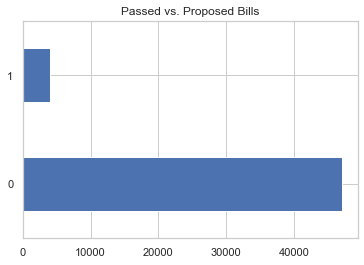

In [639]:
import seaborn as sns
sns.set(style="whitegrid")
sns.color_palette("Blues")

df['PassH'].value_counts().plot.barh().set_title('Passed vs. Proposed Bills')

Text(0.5, 1.0, 'Bills Proposed by Chamber')

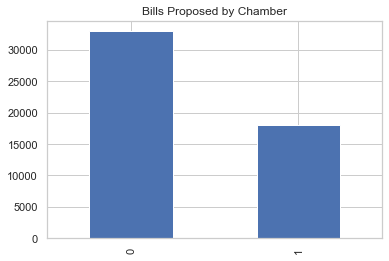

In [640]:
df['Chamber'].value_counts().plot.bar().set_title('Bills Proposed by Chamber')

Text(0.5, 1.0, 'Bill Passage in House per Congress')

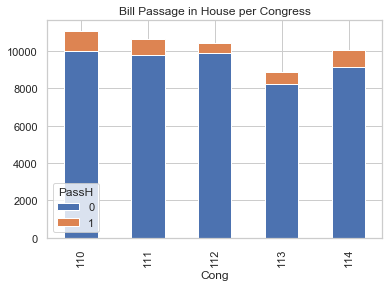

In [641]:
#Portion of bills proposed for all congresses vs those that passed the house 
sns.color_palette("Blues")
df.groupby(['Cong', 'PassH']).size().unstack().plot.bar(stacked=True).set_title('Bill Passage in House per Congress')


Text(0.5, 1.0, 'Bill Passage Senate per Congress')

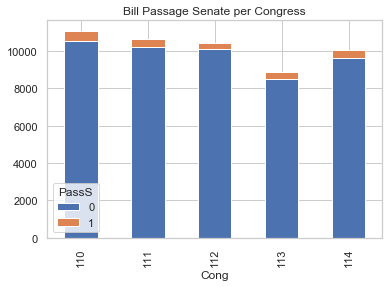

In [642]:
#Portion of bills proposed for all congresses vs those that passed the house 
df.groupby(['Cong', 'PassS']).size().unstack().plot.bar(stacked=True).set_title('Bill Passage Senate per Congress')


Text(0.5, 1.0, 'Bill Proposal by Party')

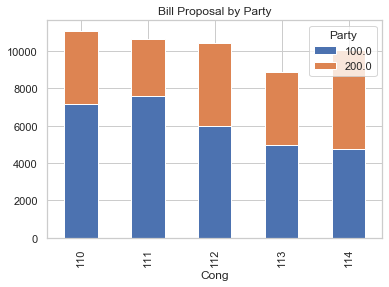

In [643]:
df.groupby(['Cong', 'Party']).size().unstack().plot.bar(stacked=True).set_title('Bill Proposal by Party')


Text(0.5, 1.0, 'Bill Passage by Majority')

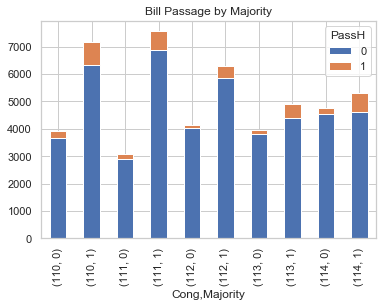

In [644]:
df.groupby(['Cong', 'Majority', 'PassH']).size().unstack().plot.bar(stacked=True).set_title('Bill Passage by Majority')


Text(0.5, 1.0, 'Bill Proposal by Majority')

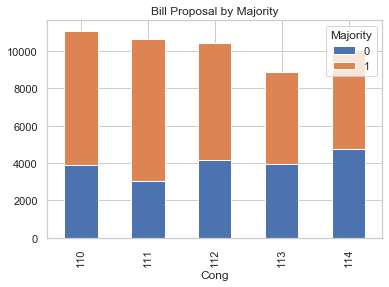

In [645]:
df.groupby(['Cong', 'Majority']).size().unstack().plot.bar(stacked=True).set_title('Bill Proposal by Majority')


Text(0.5, 1.0, 'Proportion of Bills Proposed by Party, per Congress')

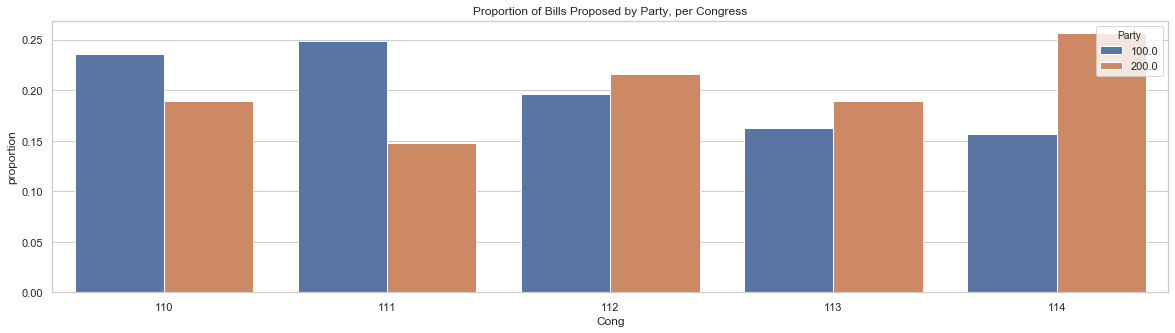

In [646]:
#Proportional Party breakdown by Congress
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x, y, hue = "Cong", "proportion", "Party"
hue_order = ["1", "0"]
data=df

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)).set_title('Proportion of Bills Proposed by Party, per Congress')


In [647]:
df.shape

(51060, 34)

# Vizualizations by Recommending Congressperson

**Exploration by Congressperson Gender:**

Text(0.5, 1.0, 'Bill Proposal by Gender')

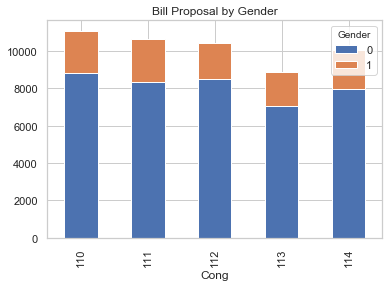

In [648]:
#All bills proposed in each congress, by Gender

df.groupby(['Cong', 'Gender']).size().unstack().plot.bar(stacked=True).set_title('Bill Proposal by Gender')


**Exploration of Party Breakdown by Congress:**

Text(0.5, 1.0, 'Proportion Bill Passage in House by Congress')

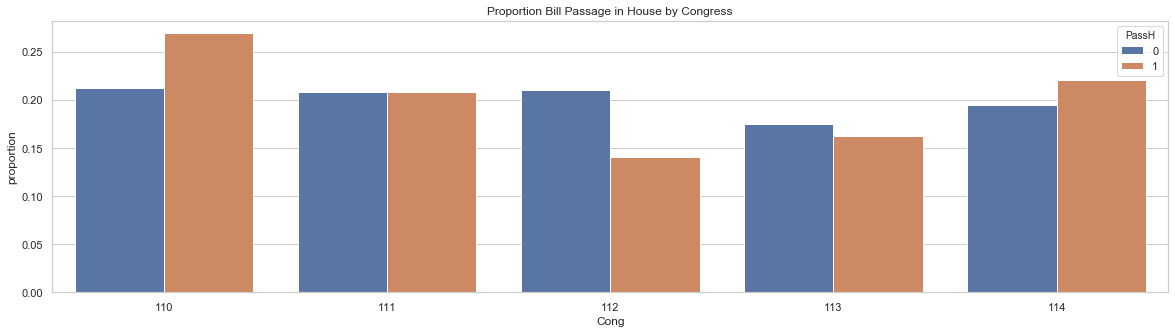

In [649]:
#Proportional Party breakdown by Congress
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x, y, hue = "Cong", "proportion", "PassH"
hue_order = ["1", "0"]
data=df

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)
 .set_title('Proportion Bill Passage in House by Congress'))


# Visualization by State, District

.size includes NaN values, .count does not

Text(0.5, 1.0, 'Party breakdown by State')

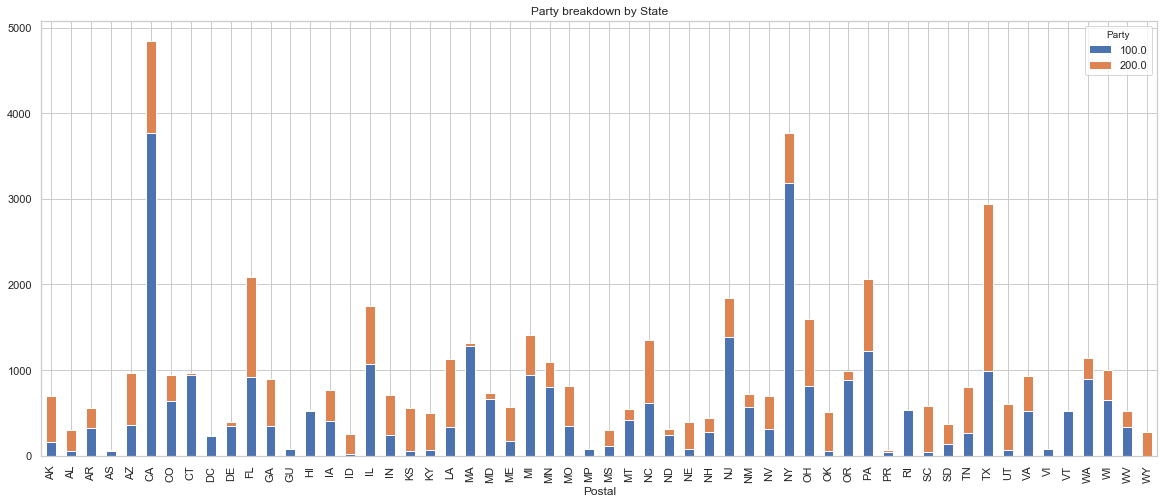

In [650]:
#Breakdown of bills proposed by party by state

df.groupby(['Postal', 'Party']).size().unstack().plot.bar(figsize=(20,8), stacked=True).set_title('Party breakdown by State')

Text(0.5, 1.0, 'State Bill Proposal Breakdown by Congressperson Party')

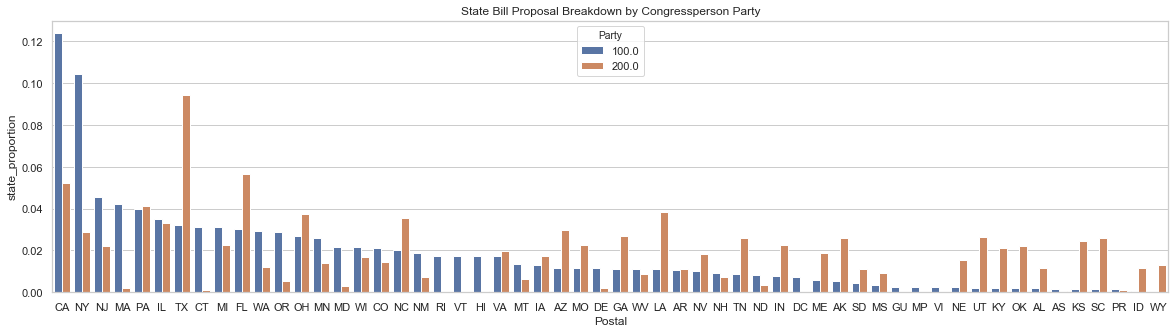

In [651]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x, y, hue = "Postal", "state_proportion", "Party"
hue_order = ["100", "200"]
data=df_test

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)).set_title('State Bill Proposal Breakdown by Congressperson Party')


Text(0.5, 1.0, 'Bill Passage by State')

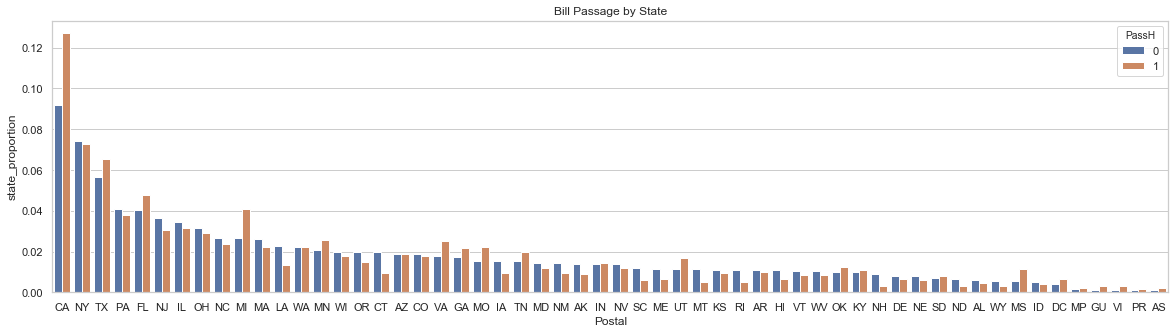

In [652]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(20,5))

x, y, hue = "Postal", "state_proportion", "PassH"
hue_order = ["1", "0"]
data=df_test

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue)).set_title('Bill Passage by State')


In [653]:
df.shape

(51060, 34)

**Mapped Bill Passage by State**

In [654]:
#Find percent bills passed for each state

total_bills = df.groupby('Postal').size()
proposed_bills = df[df['PassH'] == 1].groupby('Postal').size()
# df_success_rage = pd.concat(total_bills.to_frame(), proposed_bills.to_frame())
def percentage(x, y):
    return x / y * 100

percent_bills = proposed_bills.combine(total_bills, percentage)

In [655]:
percent_df = percent_bills.to_frame()

In [656]:
percent_df = percent_df.reset_index()

In [657]:
percent_df = percent_df[~percent_df['Postal'].isin(['AS', 'GU', 'PR', 'VI', 'DC'])]
len(percent_df)

51

In [658]:
percent_df = percent_df.rename(columns={"Postal": "State", 0: "Percent_Passed"})

In [659]:
percent_df.head()

,State,Percent_Passed
0,AK,5.278174
1,AL,6.333333
2,AR,7.454545
4,AZ,7.788162
5,CA,10.562216


In [660]:
import plotly.express as px  # Be sure to import express

colorscale='RdBu'

fig = px.choropleth(percent_df,  # Input Pandas DataFrame
                    locations="State",  # DataFrame column with locations
                    color="Percent_Passed",  # DataFrame column with color values
                    hover_name="State", # DataFrame column hover info
                    locationmode = 'USA-states') # Set to plot as US States
fig.update_layout(
    title_text = 'Percentage of Passed Bills by Proposing State Representative', # Create a Title
    geo_scope='usa',
)
fig.show()  # Output the plot to the screen

# Exploration of Bills by Topic (LDA)

In [662]:
import plotly.express as px
fig = px.histogram(df, x="dominant_topic", barmode="group",
             facet_row="PassH", facet_col="Cong",
             category_orders={"Cong": ["110", "111", "112", "113", "114"],
                              "PassH": ["0", "1"]})
fig.layout.yaxis1.update(matches=None)
fig.show()

In [619]:
topics_df = df.groupby(['Cong', 'dominant_topic', 'PassH']).size()


In [720]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# layout = {
#     'title_text':'Industrial Production Y/Y Growth Level %s by Subsector',
#     'colorscale': {'categorical':'dark24'}
# }

fig = make_subplots(
    rows=13, cols=5, shared_xaxes=True, vertical_spacing=0.02
) 
fig = px.histogram(df, x="PassH", barmode="group",
            facet_row="dominant_topic", facet_col="Cong",
            category_orders={"Cong": ["110", "111", "112", "113", "114"],
                            "dominant_topic": ["0", "1", "2", "3", "4", "5", "6","7","8","9","10","11","12","13"]})


fig.update_layout(
    title="All Topics by Congress",
    xaxis_title="Pass House",
    yaxis_title="Count Proposed",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.update_layout(height=2000, width=800, title_text="All Bills Passed by Congress and Topic")
fig.show()

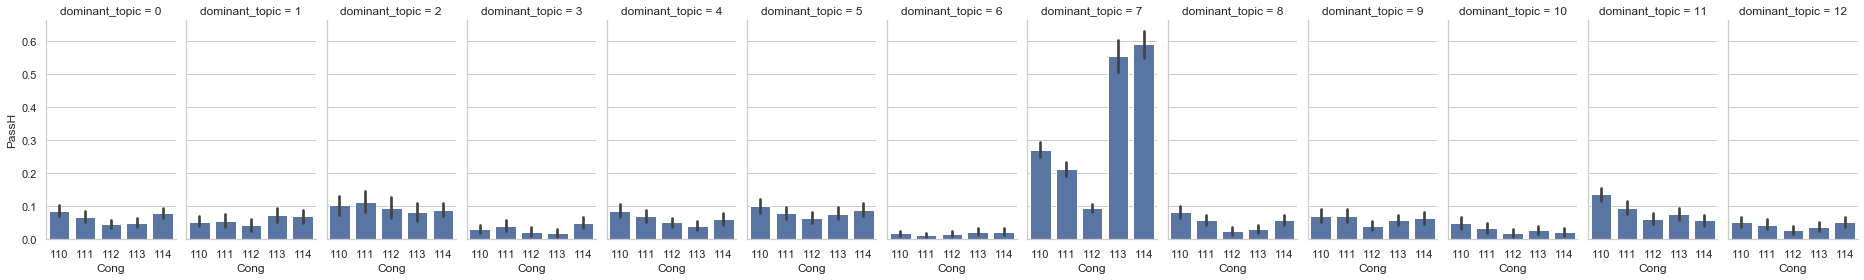

In [665]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# nr_rows = 13
# nr_cols = 5

# cols_review = ['Cong', 'PassH', 'dominant_topic']

g = sns.FacetGrid(df, col="dominant_topic", height=4, aspect=.5)
g.map(sns.barplot, "Cong", "PassH");

In [692]:
# df = df[["Year", "Sport", "Country", "Gender", "Event", "Medal"]].drop_duplicates()

passed_topics = passed_bills.groupby(["Cong", "dominant_topic"])["PassH"].count().unstack()
passed_topics

dominant_topic,0,1,2,3,4,5,6,7,8,9,10,11,12
Cong,,,,,,,,,,,,,
110,98,41,50,21,71,73,22,381,74,45,25,141,40
111,68,35,49,27,49,67,16,286,54,46,17,88,34
112,45,23,32,11,34,53,15,235,17,28,8,50,16
113,55,40,37,9,29,65,19,230,20,42,13,69,26
114,106,49,58,35,38,68,23,313,45,52,11,48,40


Text(0.5, 1.0, 'Topics by Congress and Title')

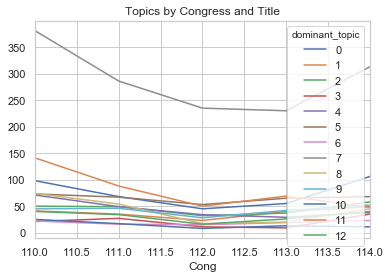

In [707]:
passed_topics.plot().set_title('Topics by Congress and Title')

In [683]:
# passed_topics = passed_topics.rename(columns = {0: 'border_enforcement', 1: 'taxes', 2: 'grants_higher_ed', 3: 'healthcare', 4: 'budget_appropriations', 
#               5: 'us_interior', 6: 'military', 7: 'designations', 8: 'energy_fuel', 9: 'entitlements_ss', 10: 'tariffs', 
#               11: 'education', 12: 'veterans_affairs'}, inplace=True)

In [482]:
# y0 = passed_topics[0]
# y1 = passed_topics[1]
# y2 = passed_topics[2]
# y3 = passed_topics[3]
# y4 = passed_topics[4]
# y5 = passed_topics[5]


In [ ]:
# plt.figure(figsize=(12,8))
# sm.T.plot.area(color=colors, ax=plt.gca(), alpha=0.5)

# # Reverse the order of labels, so they match the data
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles[::-1], labels[::-1])

# # Set labels and remove superfluous plot elements
# plt.ylabel("Number of medals")
# plt.title("Stacked areachart of select countries' medals at the Summer Olympics")
# plt.xticks(sm.columns, rotation=90)
# sns.despine()

In [696]:
passed_topics_names = passed_bills.groupby(["Cong", "dominant_topic_named"])["PassH"].count().unstack()
passed_topics_names

dominant_topic_named,border_enforcement,budget_appropriations,designations,education,energy_fuel,entitlements_ss,grants_higher_ed,healthcare,military,tariffs,taxes,us_interior,veterans_affairs
Cong,,,,,,,,,,,,,
110,98,71,381,141,74,45,50,21,22,25,41,73,40
111,68,49,286,88,54,46,49,27,16,17,35,67,34
112,45,34,235,50,17,28,32,11,15,8,23,53,16
113,55,29,230,69,20,42,37,9,19,13,40,65,26
114,106,38,313,48,45,52,58,35,23,11,49,68,40


In [706]:
topic_list

import plotly.graph_objects as go

x=[110,111,112,113,114]

y = topic_list

fig = go.Figure()

# for item in topic_list:
# #     if i == 7:
# #         continue
fig.add_trace(go.Scatter(
    x=x, y=passed_topics_names,
#         hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5),
    stackgroup='one',
    groupnorm='percent'
    ))

fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))
fig.show()

In [732]:
import plotly.graph_objects as go

x=[110,111,112,113,114]

fig = go.Figure()

for i in range(13):
#     if i == 7:
#         continue
    fig.add_trace(go.Scatter(
        x=x, y=passed_topics[i],
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        groupnorm='percent'
    ))
    
fig.update_layout(
    title="Passed Topics by Congress",
    xaxis_title="Congress",
    yaxis_title="Percent Topic",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))
fig.show()

In [729]:
not_passed_topics = not_passed_bills.groupby(["Cong", "dominant_topic"])["PassH"].count().unstack()
not_passed_topics

dominant_topic,0,1,2,3,4,5,6,7,8,9,10,11,12
Cong,,,,,,,,,,,,,
110,1027,722,438,653,753,658,1195,1023,817,585,487,895,746
111,944,588,381,630,650,782,1256,1048,872,604,478,829,731
112,931,516,302,465,634,753,914,2251,677,667,428,757,574
113,1034,506,412,481,676,775,836,185,647,678,467,824,691
114,1236,660,591,671,594,697,970,216,736,746,518,793,734


In [731]:
import plotly.graph_objects as go

x=[110,111,112,113,114]

fig = go.Figure()

for i in range(13):
#     if i == 7:
#         continue
    fig.add_trace(go.Scatter(
        x=x, y=not_passed_topics[i],
        hoverinfo='x+y',
        mode='lines',
        line=dict(width=0.5),
        stackgroup='one',
        groupnorm='percent'
    ))
    
fig.update_layout(
    title="NOT Passed Topics by Congress",
    xaxis_title="Congress",
    yaxis_title="Percent Topic",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)

fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))
fig.show()

# Natural Language Processing - Final EDA

Text(0.5, 1.0, 'Length of Title/Summary Text by Congress - Not Pass and Pass')

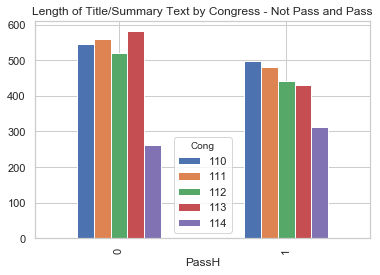

In [50]:
df.groupby(['PassH','Cong'])['text_len'].agg('mean').unstack().plot.bar().set_title('Length of Title/Summary Text by Congress - Not Pass and Pass')

Text(0.5, 1.0, 'Median Length of Title Text by Congress')

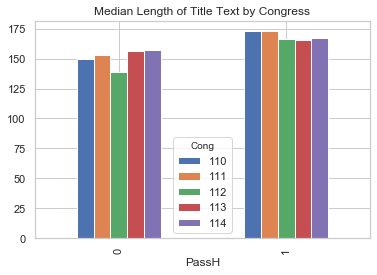

In [51]:
df.groupby(['PassH','Cong'])['title_len'].agg('median').unstack().plot.bar().set_title('Median Length of Title Text by Congress')

In [52]:
#find median length of all titles
df['title_len'].median()

153.0

In [53]:
df['summary_len'].median()

275.0

# Exploration of Passed Laws

In [54]:
#Bill vs number of Congresspersons - whip and majority or others?

In [55]:
df['NameFull'].value_counts().head()

Charles Schumer     477
Dianne Feinstein    452
Robert Casey        447
David Vitter        409
Robert Menendez     408
Name: NameFull, dtype: int64

In [56]:
from collections import Counter

all_names_dict = dict(Counter(df['NameFull']))

In [57]:
top_names = {key: value for key, value in all_names_dict.items() if value >= 100}


In [58]:
for name in sorted(top_names, key=top_names.get, reverse = True):
    print(name, top_names[name])

Charles Schumer 477
Dianne Feinstein 452
Robert Casey 447
David Vitter 409
Robert Menendez 408
Sherrod Brown 393
Ron Wyden 317
Amy Klobuchar 296
Barbara Boxer 295
John Kerry 287
Richard Durbin 285
Carolyn Maloney 267
Don Young 262
Kirsten Gillibrand 250
Edward Markey 242
Sheila Jackson Lee 233
Eleanor Norton 226
Lisa Murkowski 224
Orrin Hatch 219
Mary Landrieu 217
Jon Tester 214
Alan Grayson 214
Patrick Leahy 213
Jeff Bingaman 212
Carl Levin 210
John Rockefeller 209
Steve Israel 206
Benjamin Cardin 203
Patty Murray 203
Thomas Harkin 202
Charles Grassley 202
Frank Lautenberg 199
Max Baucus 199
Bill Nelson 199
Olympia Snowe 193
Kay Hagan 192
Maria Cantwell 191
Harry Reid 189
John Cornyn 189
John Reed 187
Bernard Sanders 185
John Conyers 184
Susan Collins 181
Mark Kirk 179
Ronald Paul 177
Richard Burr 176
Dean Heller 174
Bob Filner 172
James Inhofe 170
Rosa DeLauro 169
Jim McDermott 169
Mark Begich 164
Daniel Akaka 161
Earl Blumenauer 159
Richard Blumenthal 159
Mark Udall 158
Tom Udall 15

Text(0.5, 1.0, 'Ranked Congresspersons by Career Bill Proposal Count')

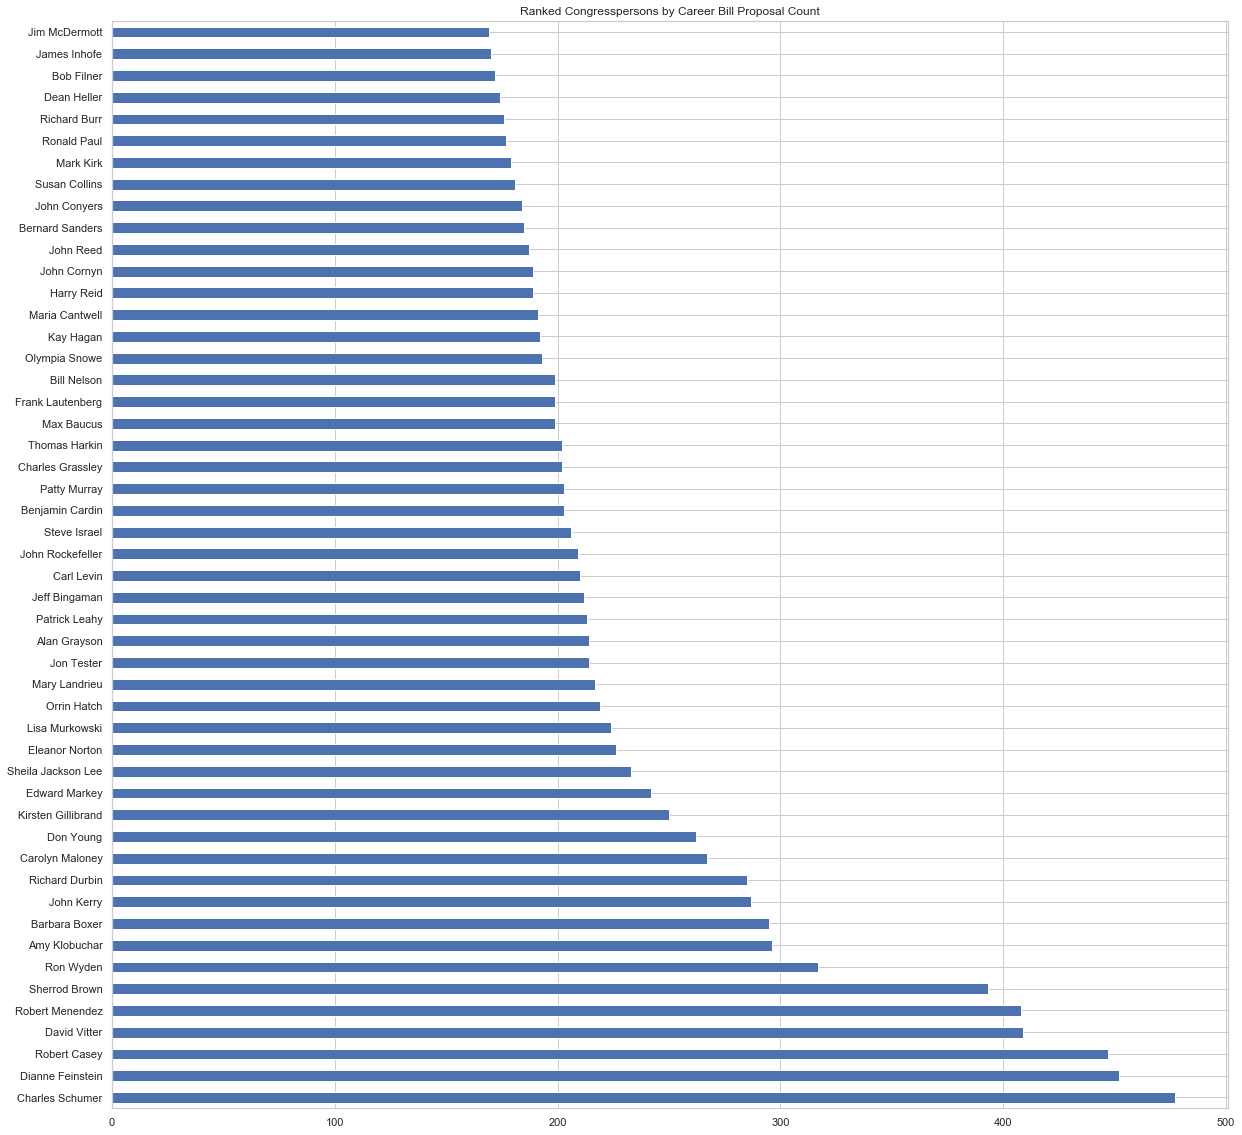

In [531]:
# The top 50 Congresspersons and number of bill introductions
#DO THIS BY PARTY

data['NameFull'].value_counts().head(50).plot(kind='barh', figsize=(20,20)).set_title('Ranked Congresspersons by Career Bill Proposal Count')